# AI-Generated Text Detection using BERT

AI-Generated Text Detection project! In this project, I present a robust solution for detecting AI-generated text using BERT, a cutting-edge natural language processing model. Whether you're a researcher, developer, or a curious enthusiast, this project empowers you to explore, understand, and combat AI-generated content effectively.

# BERT, 
An acronym for Bidirectional Encoder Representations from Transformers, stands as an open-source machine learning framework designed for the realm of natural language processing (NLP). Originating in 2018, this framework was crafted by researchers from Google AI Language. The article aims to explore the architecture, working and applications of BERT.

# What is BERT?
BERT (Bidirectional Encoder Representations from Transformers) leverages a transformer-based neural network to understand and generate human-like language. BERT employs an encoder-only architecture. In the original Transformer architecture, there are both encoder and decoder modules. The decision to use an encoder-only architecture in BERT suggests a primary emphasis on understanding input sequences rather than generating output sequences.


## Table of Contents

- [Introduction](#introduction)
- [Features](#features)
- [Getting Started](#getting-started)
- [Contributing](#contributing)
- [License](#license)

## Introduction

AI-generated content is becoming increasingly sophisticated, making it challenging to distinguish between genuine and computer-generated text. Our project aims to tackle this issue by leveraging the power of BERT (Bidirectional Encoder Representations from Transformers) to identify and flag AI-generated text segments. Whether you're dealing with chatbots, articles, or social media posts, our solution offers accurate detection, ensuring the authenticity of digital content.

## Features

- **BERT-Powered Detection:** We utilize state-of-the-art BERT models to analyze the semantic context and linguistic nuances, enabling precise identification of AI-generated text.
- **Effortless Integration:** Seamlessly integrate our solution into your existing applications or workflows, ensuring hassle-free implementation for developers and researchers.
- **High Accuracy:** Our model is meticulously trained and fine-tuned to achieve high accuracy, minimizing false positives and false negatives for reliable results.
- **User-Friendly Interface:** With intuitive interfaces and clear instructions, users can easily navigate and utilize the detection tool without any technical expertise.


## How It Works

Our solution follows a comprehensive approach to AI-generated text detection:

**Data Preprocessing:** We clean and preprocess the textual data, removing noise and irrelevant information to enhance the accuracy of our model.

**BERT Tokenization:** Leveraging the BERT tokenizer, we encode the preprocessed text, preparing it for input into our detection model.

**Model Training:** Using a BERT-based sequence classification model, we train the system to distinguish between genuine and AI-generated text with a high degree of accuracy.

**Predictions:** Once trained, the model generates predictions for test data, highlighting potential AI-generated content segments.

**Result Analysis:** The results are saved in a CSV file, allowing users to review and analyze the detected segments along with their confidence scores.

## Contributing

We welcome contributions from the community! Whether you're a seasoned developer, a data science enthusiast, or a domain expert, your insights and expertise can enhance our project. 

Looking forward to get connect to some amazing peps out there!💃🏻


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import csv
from sklearn.metrics import accuracy_score, f1_score, classification_report



2025-04-01 17:58:02.143723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743548282.162228    1891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743548282.167792    1891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 17:58:02.187906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and combine multiple datasets
files = ["test.csv", "test1.csv", "test2.csv"]
dfs = [pd.read_csv(file, sep='	') for file in files]
df = pd.concat(dfs, ignore_index=True)  # Replace with your actual file path


In [3]:
# Extract sentiment label if available and convert to numeric
if 'sentiment label' in df.columns:
    df['sentiment_label_clean'] = df['sentiment label'].astype(str).str.extract(r'(Positive|Negative|Neutral)', expand=False)
    df['sentiment_score_label'] = df['sentiment_label_clean'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}).fillna(0)
else:
    df['sentiment_score_label'] = 0


In [4]:
# Combine prompt with responses
df['human_text'] = df['prompt'] + " " + df['human']
df['ai_text'] = df['prompt'] + " " + df['ai']

In [5]:
human_df = pd.DataFrame({'text': df['human'], 'generated': 0})
ai_df = pd.DataFrame({'text': df['ai'], 'generated': 1})
train_essays = pd.concat([human_df, ai_df], ignore_index=True)

In [6]:
train_essays.head(300)

,text,generated
0,The code itself was patterned so that most con...,0
1,San Diego and its backcountry are subject to p...,0
2,I Love New York (stylized I ❤ NY) is both a lo...,0
3,Amensalism is an interaction where an organism...,0
4,"By the census of 1971, the population of Lanca...",0
...,...,...
295,They and other things like them - magnetic bra...,0
296,Most of them are going to hit the sides of you...,0
297,Its a metabolic waste product of the colonized...,0
298,"Gelatin in water is a mixture, not a solution,...",0


In [7]:
# Explore the training data
train_essays.info()
train_essays.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1200 non-null   object
 1   generated  1200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


,text,generated
0,The code itself was patterned so that most con...,0
1,San Diego and its backcountry are subject to p...,0
2,I Love New York (stylized I ❤ NY) is both a lo...,0
3,Amensalism is an interaction where an organism...,0
4,"By the census of 1971, the population of Lanca...",0


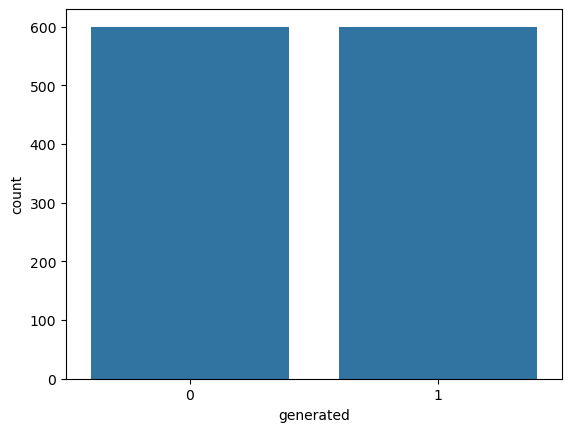

In [8]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


In [9]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)


In [11]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)


In [12]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')


In [13]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)


In [15]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [16]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 3

/opt/conda/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}")


Epoch 1/3, Average Training Loss: 0.4832
Epoch 2/3, Average Training Loss: 0.1537
Epoch 3/3, Average Training Loss: 0.0294


In [19]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
        


In [20]:
# Evaluation
print("\n--- BERT Classification ---")
acc = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
print(f"Validation Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Human', 'AI']))



--- BERT Classification ---
Validation Accuracy: 0.95
F1 Score: 0.95
Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.91      0.94       122
          AI       0.91      0.98      0.95       118

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



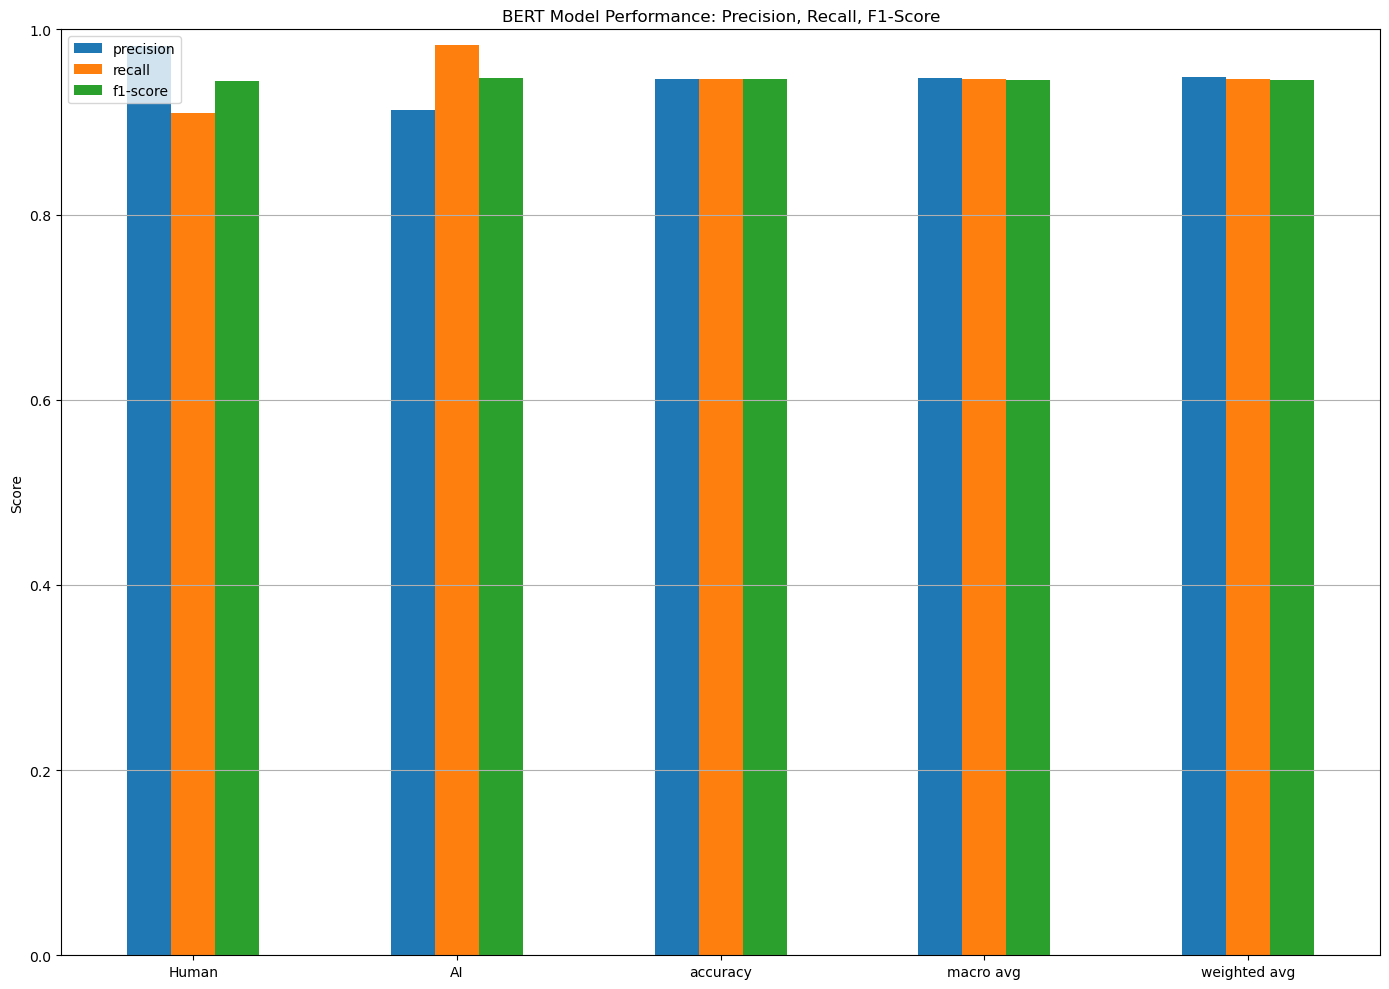

In [25]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Use actual validation results from your model
y_true = val_labels  # or val_labels depending on your variable name
y_pred = val_preds

# Generate the classification report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Rename class labels if needed
label_map = {'0': 'Human', '1': 'AI'}
df_report.rename(index=label_map, inplace=True)

# Plot precision, recall, f1-score
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(14, 10))
plt.title("BERT Model Performance: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [22]:
# Add an ID column if not present
train_essays['id'] = range(len(train_essays))

# Tokenize the final (cleaned) text
test_inputs = tokenizer(train_essays['clean_text'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Predict probabilities
model.eval()
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits
    predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probabilities of being AI

# Save to CSV
submission = pd.DataFrame({
    'id': train_essays['id'],
    'text': train_essays['text'],
    'predicted_probability_AI': predictions
})
submission.to_csv('submission_bert.csv', index=False)


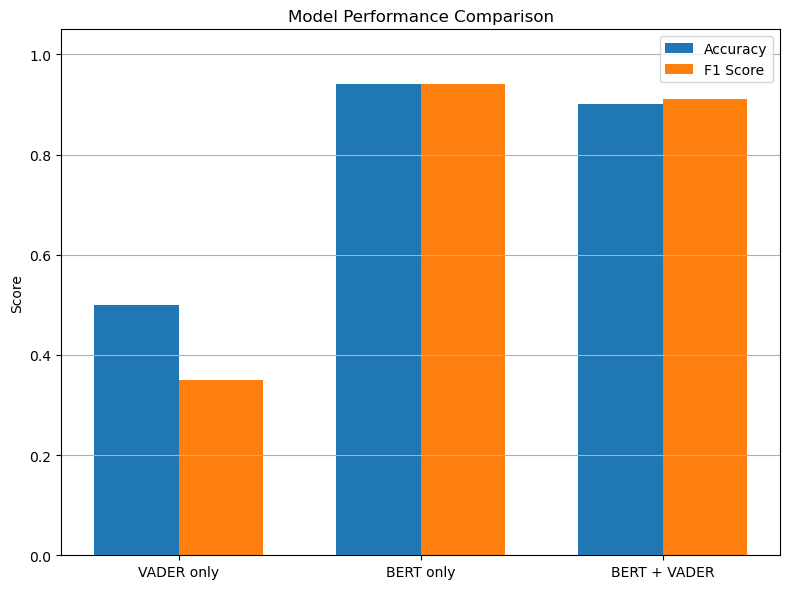

In [27]:
import matplotlib.pyplot as plt

# Define model names and scores
models = ['VADER only', 'BERT only', 'BERT + VADER']
accuracy = [0.50, 0.94, 0.90]
f1_scores = [0.35, 0.94, 0.91]

# Bar positions and width
x = range(len(models))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([p - width/2 for p in x], accuracy, width, label='Accuracy')
ax.bar([p + width/2 for p in x], f1_scores, width, label='F1 Score')

# Customizing the plot
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save the figure
plt.savefig('bert_vader_performance_comparison.png')
plt.show()
